In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt 
import scanpy as sc
from scipy.io import mmread
import warnings

%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)

---

Save the raw count matrices to AnnData 

In [33]:
# data_dir = Path("data/raw/A1")  # Change last part for each dataset {A1, A2, B1, B2, ...}
# X = mmread(data_dir.joinpath("matrix.mtx.gz")).T.tocsr()
# barcodes = pd.read_csv(data_dir.joinpath("barcodes.tsv.gz"), header=None, index_col=0, delimiter="\t")
# barcodes.index.name = "barcodes"
# genes = pd.read_csv(data_dir.joinpath("features.tsv.gz"), header=None, index_col=1, delimiter="\t")
# genes.index.name = "gene_symbols"
# genes.columns = ["gene_ids", "feature_types"]

# # Create and save the AnnData object
# adata = sc.AnnData(X=X, obs=barcodes, var=genes)
# adata.var_names_make_unique()
# adata.write(data_dir.joinpath("adata.h5ad"))

/home/ec2-user/mambaforge-pypy3/envs/synnotch-materials/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


---


### Filter out cells with high % mitochondrial reads

In [86]:
import seaborn as sns

sample = "D2"

<Figure size 1000x1000 with 0 Axes>

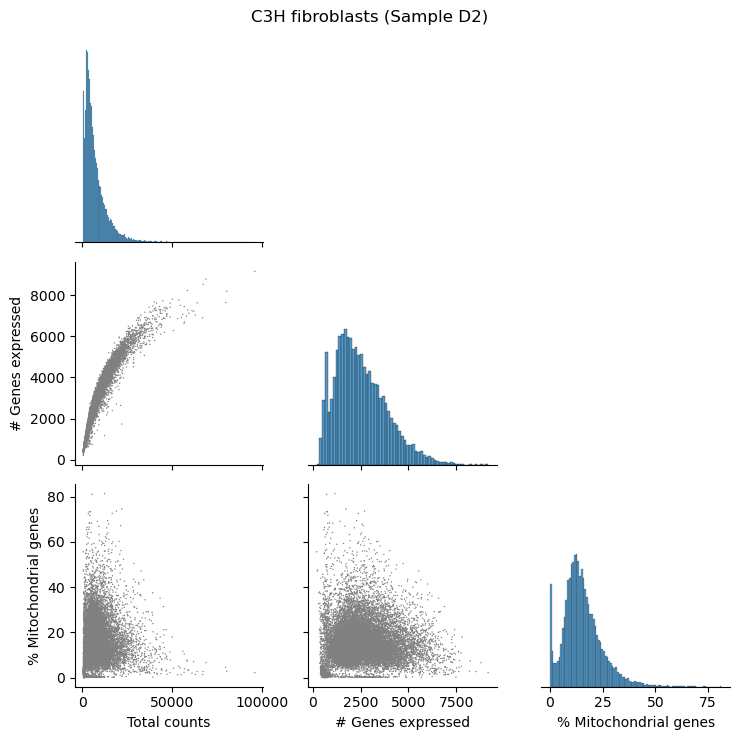

In [87]:
# Perform basic filtering
adata = sc.read(f"data/raw/{sample}/adata.h5ad")
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plot a pairplot of the covariates
df = adata.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']]
df.columns = ['Total counts', '# Genes expressed', '% Mitochondrial genes']

fig = plt.figure(figsize=(10, 10))
sns.pairplot(
    df,
    corner=True,
    plot_kws=dict(marker='o', alpha=1, color='gray', edgecolor='none', s=1),
)

plt.suptitle(f"C3H fibroblasts (Sample {sample})")
plt.tight_layout()

In [88]:
# Perform filtering based on mitochondrial genes
mt_pct_thresh = 25
adata = adata[adata.obs['pct_counts_mt'] < mt_pct_thresh, :]

# Normalize to 10,000 counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

# Save the filtered and normalized AnnData object
adata.write(f"data/normalized/{sample}_filtered_normalized.h5ad")

/home/ec2-user/mambaforge-pypy3/envs/synnotch-materials/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


---

## Aggregate and batch correct

---

In [36]:
import anndata
import scvi

adata = anndata.read("data/raw/A1/adata.h5ad")
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 33/400:   8%|▊         | 32/400 [02:10<24:25,  3.98s/it, v_num=1, train_loss_step=8.82e+3, train_loss_epoch=8.54e+3]

/home/ec2-user/mambaforge-pypy3/envs/synnotch-materials/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [35]:
adata

AnnData object with n_obs × n_vars = 16328 × 32285
    obs: '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

In [3]:
import os
import tempfile

import scanpy as sc
import scvi
import torch
from rich import print
# from scib_metrics.benchmark import Benchmarker